### SageMaker PCA
haimtran 03 OCT 2022 

[payload max size](https://docs.aws.amazon.com/general/latest/gr/sagemaker.html)

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import boto3
import sagemaker
from sagemaker.amazon.pca import PCA
from sagemaker.amazon.amazon_estimator import RecordSet
from sagemaker import PCAPredictor
from sagemaker import get_execution_role
import json

In [3]:
%matplotlib notebook

In [4]:
role = get_execution_role()

In [5]:
sess = sagemaker.Session()

In [6]:
default_bucket = sess.default_bucket()

### download data from s3 

In [7]:
s3_client = boto3.client('s3')

In [8]:
#s3_client.download_file(default_bucket, "ecg/171A_raw.csv", "171A_raw.csv")

### explore data 

In [9]:
# pandas can read directly from s3 
df = pd.read_csv(f"s3://{default_bucket}/ecg/171A_raw.csv",header=0,decimal=",",low_memory=False)

In [10]:
df.head()

,Real Time,Ch5,Ch6,Ch7,Ch8,BioRadio Event,Unnamed: 6
0,2021-12-09 12:20:46.3935,-0.00483427941799164,0.00440751761198044,0.00478646904230118,0.0098966583609581,0,NaN
1,2021-12-09 12:20:46.3955,-0.00482828915119171,0.00441303849220276,0.00479216873645782,0.00990407913923264,0,NaN
2,2021-12-09 12:20:46.3975,-0.00483635812997818,0.00440700352191925,0.0047864243388176,0.00989764183759689,0,NaN
3,2021-12-09 12:20:46.3995,-0.00485609471797943,0.00439200550317764,0.00477075576782227,0.00988166034221649,0,NaN
4,2021-12-09 12:20:46.4015,-0.00481210649013519,0.00442609190940857,0.00480430573225021,0.00991485267877579,0,NaN


In [11]:
df.fillna(0, inplace=True)

In [12]:
ecg = df[['Ch5', 'Ch6', 'Ch7', 'Ch8']].values.astype(dtype=np.float32)

<IPython.core.display.Javascript object>


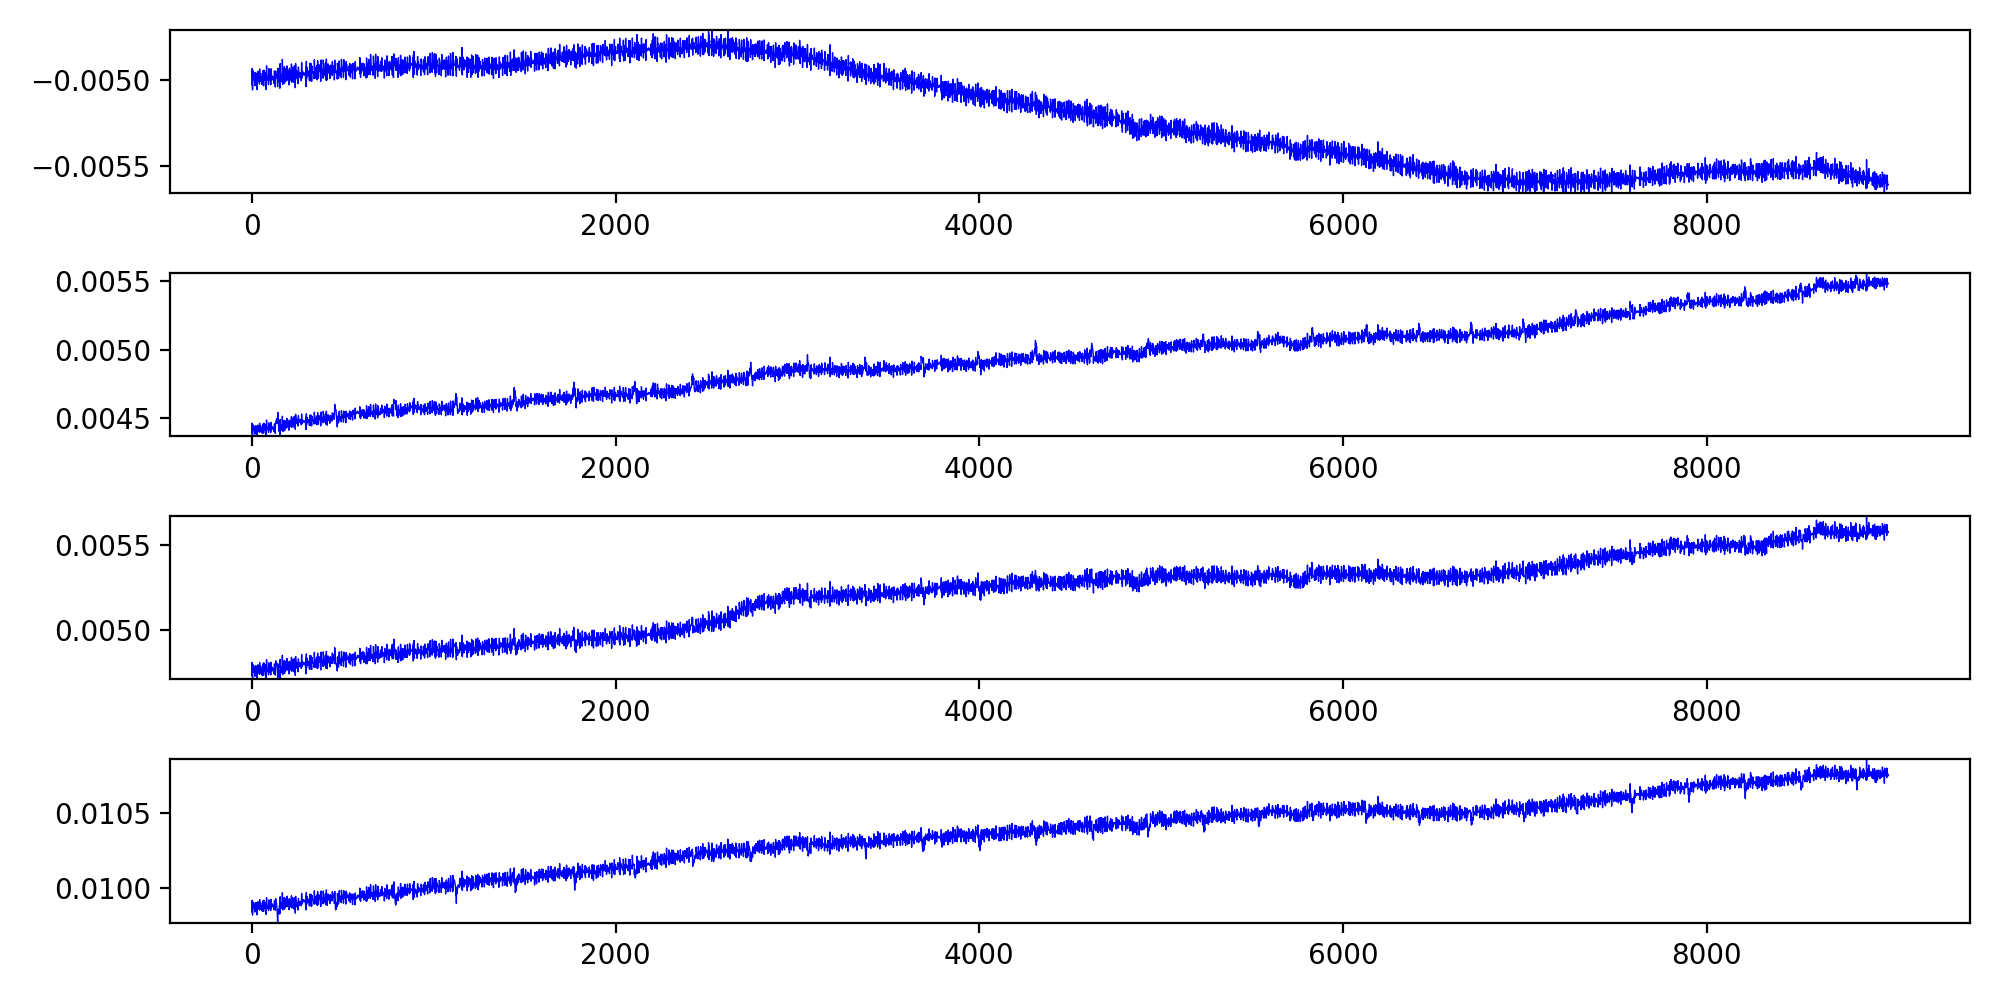

In [13]:
xmin,xmax=1000,10000
fig,axes = plt.subplots(4,1,figsize=(10,5))
for k in range(4):
    axes[k].plot(ecg[xmin:xmax,k],'b',linewidth=0.5)
    axes[k].set_ylim(np.min(ecg[xmin:xmax,k]), np.max(ecg[xmin:xmax,k]))
fig.tight_layout()
plt.show()

### feature processing 

In [14]:
normEcg = (ecg - np.mean(ecg, axis=0)) / np.std(ecg, axis=0)

<IPython.core.display.Javascript object>


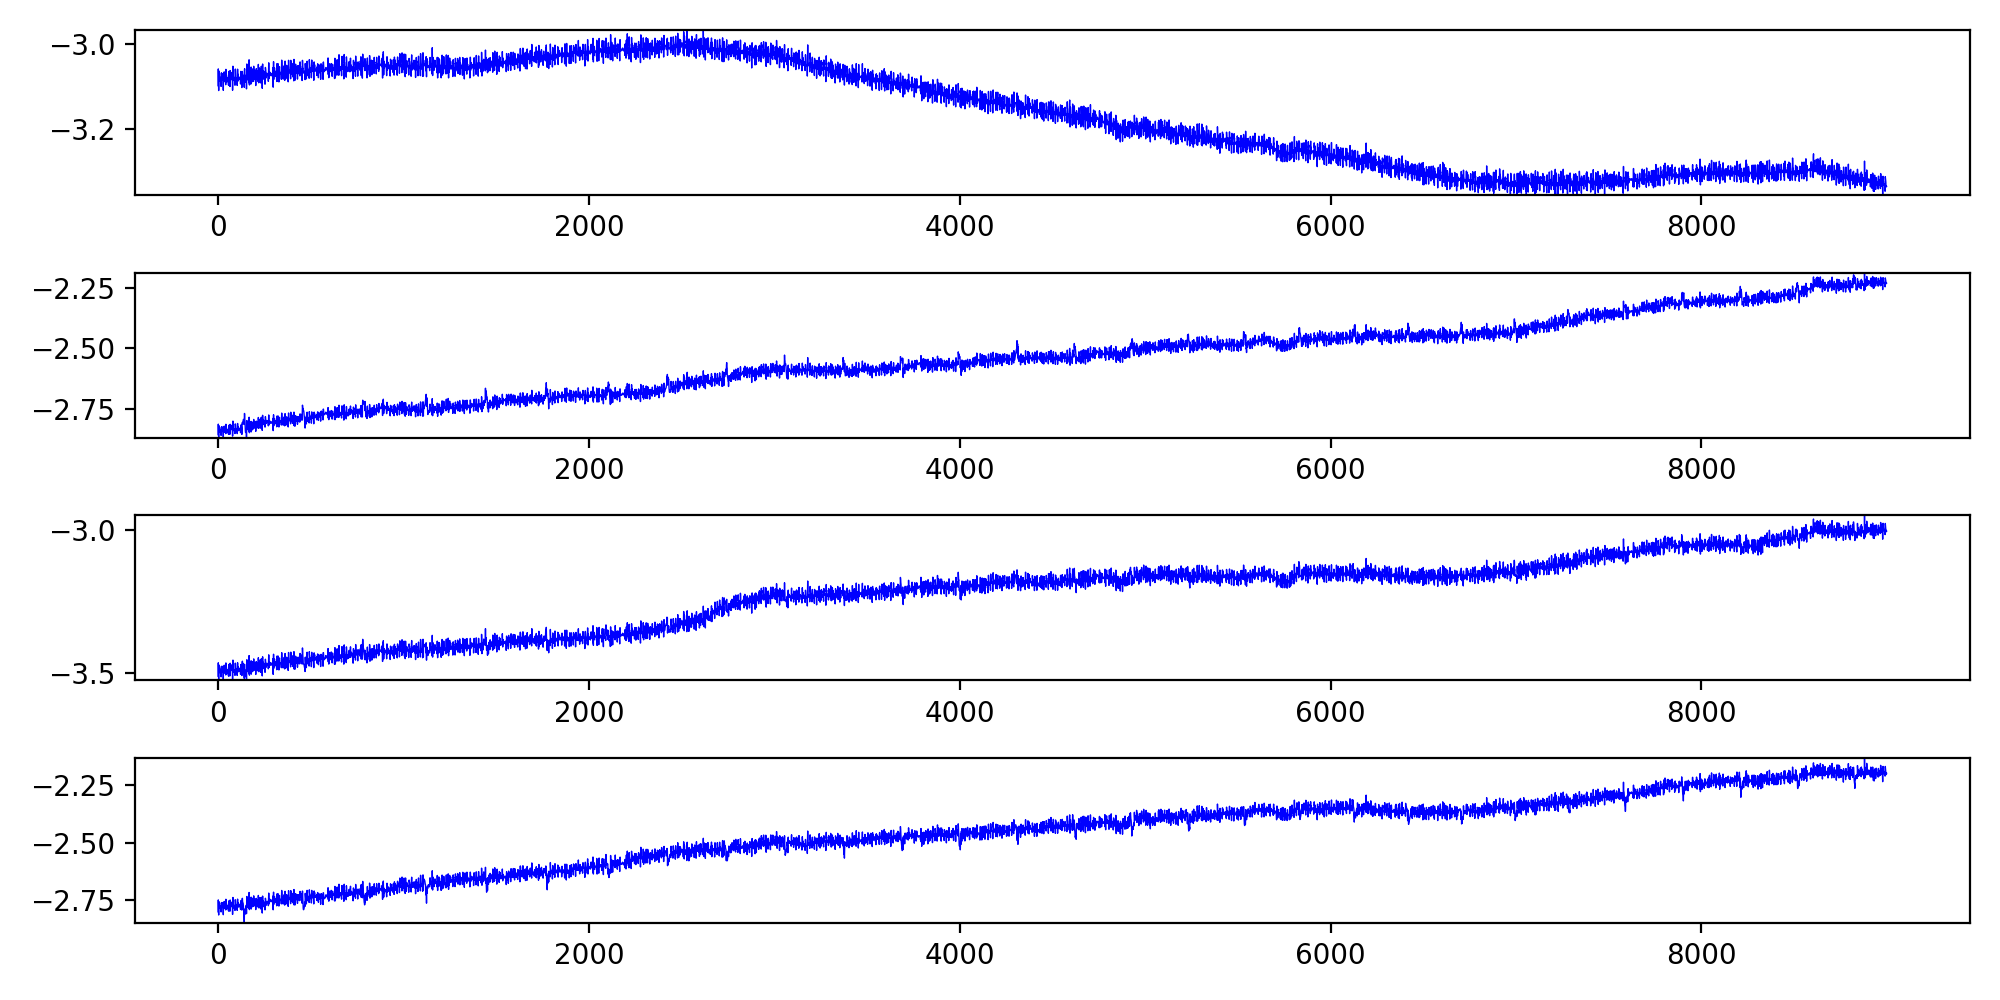

In [15]:
xmin,xmax=1000,10000
fig,axes = plt.subplots(4,1,figsize=(10,5))
for k in range(4):
    axes[k].plot(normEcg[xmin:xmax,k],'b',linewidth=0.5)
    axes[k].set_ylim(np.min(normEcg[xmin:xmax,k]), np.max(normEcg[xmin:xmax,k]))
fig.tight_layout()
plt.show()

### sagemaker pca train

In [16]:
pca = PCA(
    role=role, 
    instance_count=1, 
    instance_type='ml.c4.xlarge',
    input_mode="Pipe",
    num_components=3)

In [17]:
# construct RecordSet data
# how to construct it from s3 csv data
# record_set = pca.record_set(normEcg)
# print(record_set)

In [18]:
# # double check 
# record_set = RecordSet(
#     s3_data=f"s3://{default_bucket}/sagemaker-record-sets/PCA-2022-10-03-04-08-14-035/.amazon.manifest",
#     num_records=1557664,
#     feature_dim=4
# )
# print(record_set)

In [19]:
# fit 
# pca.fit(records=record_set)

### sagemaker pca deploy 

In [20]:
# pca.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

In [21]:
pca_predictor = PCAPredictor(
    endpoint_name="pca-2022-10-03-04-38-28-130")

In [22]:
# 413 error when data length more than threshold
result = pca_predictor.predict(normEcg[:100000,:])

In [23]:
# plot transformed data 

In [24]:
buffer = []
for x in result:
    buffer.append(x.label['projection'].float32_tensor.values)

In [25]:
buffer = np.array(buffer)

In [26]:
np.shape(buffer)

(100000, 3)

<IPython.core.display.Javascript object>


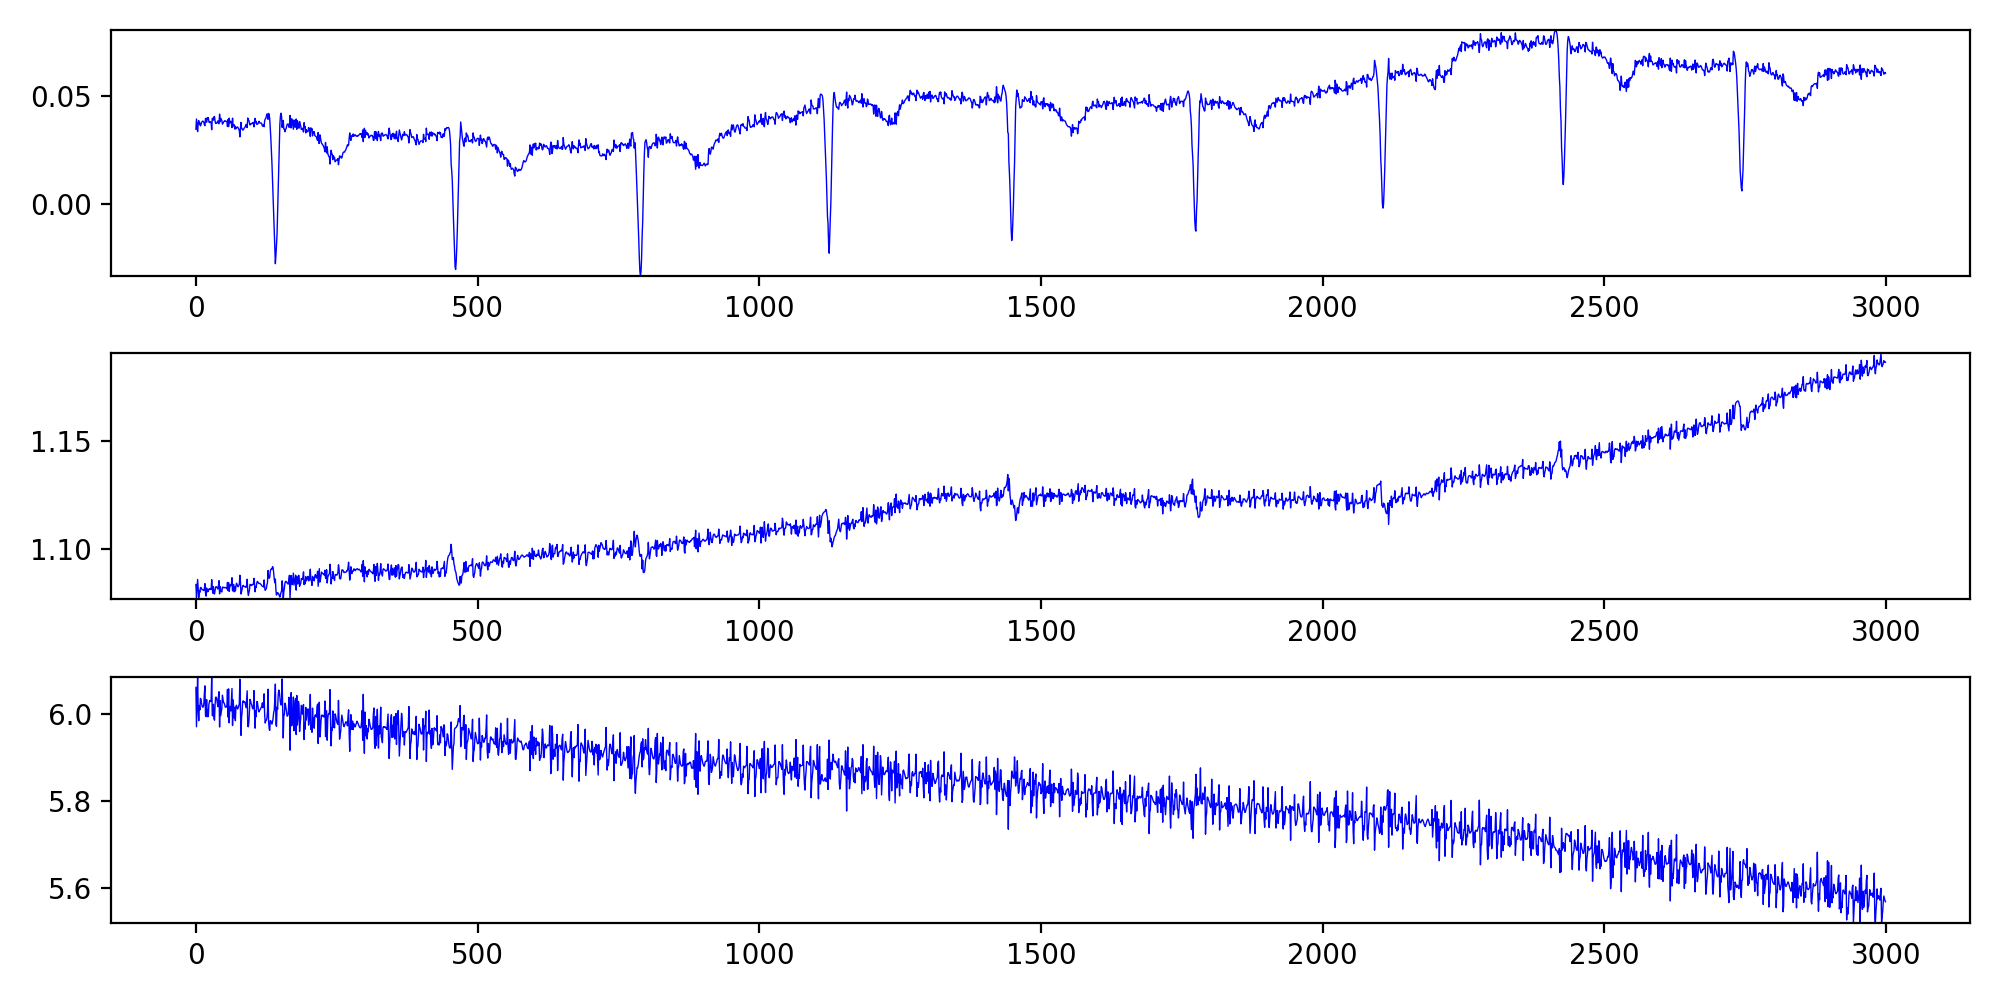

In [27]:
xmin,xmax=1000,4000
fig,axes = plt.subplots(3,1,figsize=(10,5))
for k in range(3):
    axes[k].plot(buffer[xmin:xmax,k],'b',linewidth=0.5)
    axes[k].set_ylim(np.min(buffer[xmin:xmax,k]), np.max(buffer[xmin:xmax,k]))
fig.tight_layout()
plt.show()

### batch transform 

In [28]:
from sagemaker.transformer import Transformer

In [29]:
transformer = Transformer(
    model_name="pca-2022-10-03-04-38-28-130",
    instance_count=1,
    instance_type="ml.c4.xlarge",
    strategy="MultiRecord")

In [ ]:
output = transformer.transform(
    data=f"s3://{default_bucket}/ecg/test.csv",
    content_type="text/csv",
    split_type="Line"
)

..........

In [ ]:
# print(record_set)

In [ ]:
# upload test data to s3
# np.savetxt("test_small.csv", normEcg[:10000,:], delimiter=",")
# s3_client.upload_file('test.csv', default_bucket, "ecg/test.csv")
# s3_client.upload_file('test_small.csv', default_bucket, 'ecg/test_small.csv')

In [ ]:
output_prefix = transformer.output_path.split("/")[-1]
resp = s3_client.list_objects(Bucket=default_bucket, Prefix=output_prefix)
output_file = resp["Contents"][0]
s3_client.download_file(default_bucket,output_file["Key"],"transformed.csv")

In [ ]:
with open("transformed.csv", "r") as file:
    buffer = [json.loads(line)['projection'] for line in file]

In [ ]:
transformed = np.array(buffer)

In [ ]:
xmin,xmax=35000,40000
fig,axes = plt.subplots(3,1,figsize=(10,5))
for k in range(3):
    axes[k].plot(transformed[xmin:xmax,k],'b',linewidth=0.5)
    axes[k].set_ylim(np.min(transformed[xmin:xmax,k]), np.max(transformed[xmin:xmax,k]))
fig.tight_layout()
plt.show()